Book- Crossing recomender system 

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
import seaborn as sns
#from sklearn import model_selection
from surprise import Reader, Dataset
from surprise import model_selection, accuracy
from surprise import NMF
from surprise import SVD
from surprise import SVDpp
from surprise import CoClustering
from surprise import Dataset, Reader
from surprise import SVD, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline



warnings.filterwarnings('ignore') # Turn off warnings
plt.style.use('seaborn-white') # Use seaborn-style plots
plt.rcParams.update({'font.size': 15}) # Set larger default plot font size
%matplotlib inline





**The data set was downlaoded from** "http://www2.informatik.uni-freiburg.de/~cziegler/BX/ "

In [2]:
users = pd.read_csv ("C:/Users/16472/OneDrive/Documents/Data analytics/Advanced course Big data/Course 2/Project 1/books/users.csv", sep=';', encoding='ansi')
books = pd.read_csv ("C:/Users/16472/OneDrive/Documents/Data analytics/Advanced course Big data/Course 2/Project 1/books/Books.csv", sep=';', encoding='ansi', escapechar='\\')
ratings = pd.read_csv ("C:/Users/16472/OneDrive/Documents/Data analytics/Advanced course Big data/Course 2/Project 1/books/Book-Ratings.csv", sep=';', encoding='ansi')


In [3]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [5]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


# Exploring the data sets

In [6]:
#checking the types of data in each data set
dtBooks = books.dtypes
dtratings = ratings.dtypes
dtusers = users.dtypes

print(dtBooks)

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object


In [7]:
print(dtratings)

User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


In [8]:
print(dtusers)

User-ID       int64
Location     object
Age         float64
dtype: object


In [9]:
books.info()
books.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271378 non-null  object
 3   Year-Of-Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
 5   Image-URL-S          271379 non-null  object
 6   Image-URL-M          271379 non-null  object
 7   Image-URL-L          271379 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


,Year-Of-Publication
count,271379.000000
mean,1959.756050
std,258.011363
min,0.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2050.000000


In [10]:
ratings.info()
ratings.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [11]:
users.columns = ['User_id',"Location","Age"]
users.info()
users.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User_id   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


,User_id,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [12]:
users.isna().sum()
users.isnull().sum()

User_id          0
Location         0
Age         110762
dtype: int64

In [13]:
ratings.isna().sum()
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [14]:
books.isna().sum()
#books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

## Discovery of the users data set 

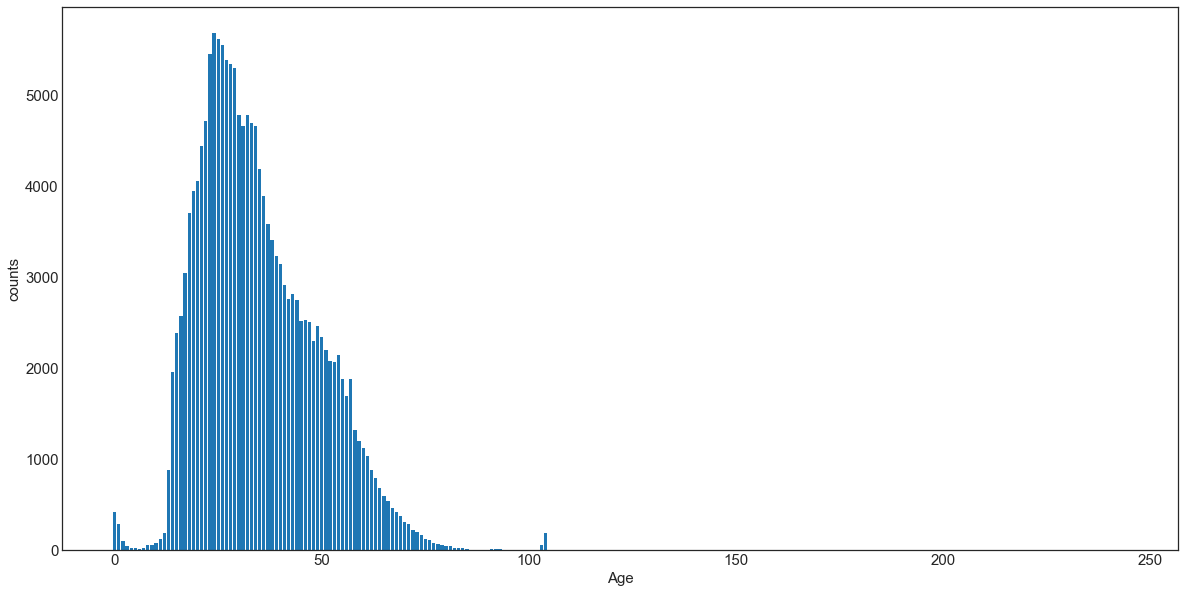

In [15]:
u = users.Age.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('counts')
plt.show()

From the above graph it seems that there are some oult liares as some users age is more than 100 and less than 10 years old
So We will be cleaning users data set by changing all the values less tha more than 100 and less than 5 years old to na

In [16]:
users.loc[(users.Age<5) | (users.Age>100), 'Age'] = np.nan
users1 = pd.DataFrame(users)



In [17]:
print(sorted(users1.Age.unique()))

[nan, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]


In [18]:
#40% of the users does not have age value which is a big number so we will try to fill all the na values with the same distribution of age 
users1.Age.isnull().sum() / len(users)

0.4016739702644357

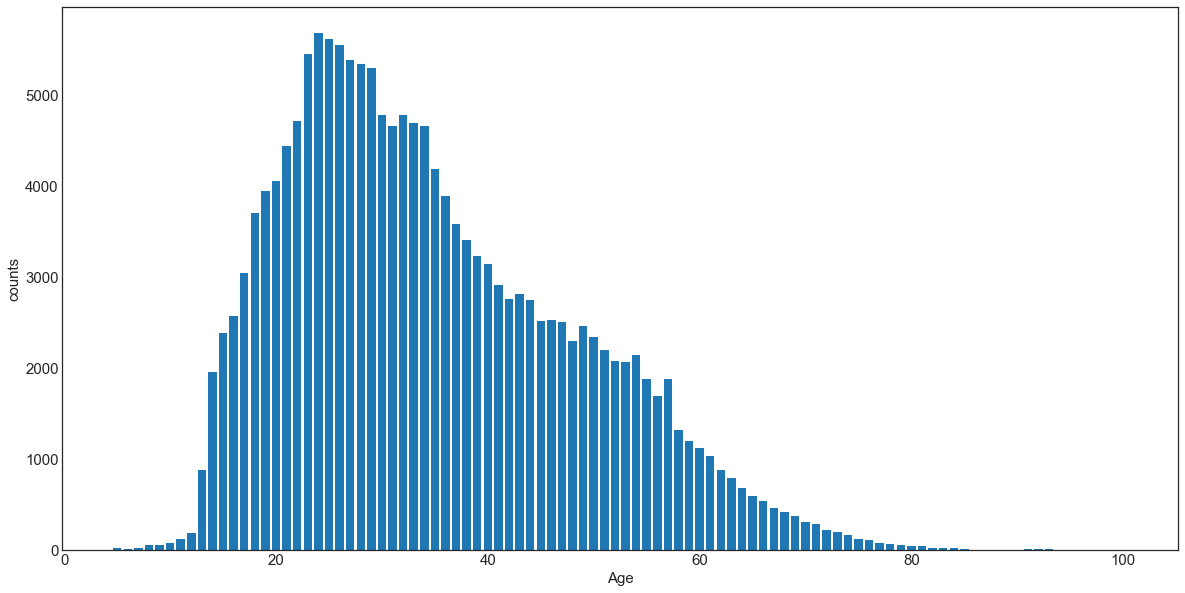

In [19]:
u = users1.Age.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('counts')
plt.show()

In [20]:
users1.Age.fillna(users1.Age.mean()).describe()

count    278858.000000
mean         34.746638
std          10.545361
min           5.000000
25%          29.000000
50%          34.746638
75%          35.000000
max         100.000000
Name: Age, dtype: float64

In [21]:
# create a normal disrtribution pd.Series to fill Nan values with
temp_age_series = pd.Series(np.random.normal(loc=users1.Age.mean(), scale=users1.Age.std(), size=users1.User_id[users1.Age.isna()].count()))
print("Describtion of the user1 dataset age") 
print(users1.Age.describe())
print("Describtion of the Age series")
print(temp_age_series.describe())
print("checking the negative values in the distribution series")
print(temp_age_series[temp_age_series<0].count())


#As we can see the destribution doesnt change a lot. There are some negative values which we will take only the absulate values for the age distribution 




Describtion of the user1 dataset age
count    166848.000000
mean         34.746638
std          13.633051
min           5.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         100.000000
Name: Age, dtype: float64
Describtion of the Age series
count    112010.000000
mean         34.709541
std          13.658802
min         -20.063203
25%          25.506363
50%          34.707204
75%          43.864922
max          92.158324
dtype: float64
checking the negative values in the distribution series
606


In [22]:
# take the abs value of temp_Age_series
pos_age_series=np.abs(temp_age_series)

# sort users1 Df so as NaN values in Age to be first and reset index to match with index of pos_Age_series. Then use fillna()
users1 = users1.sort_values('Age',na_position='first').reset_index(drop=True)
users1.Age.fillna(pos_age_series, inplace = True)
users1.loc[users1.Age<5, 'Age'] = users1.Age.mean()
users1.Age = users1.Age.round().astype(int)

#Sort users1 based on User-ID so as to be the same as before
users1 = users1.sort_values('User_id').reset_index(drop=True)
print(users1.Age.describe(),"\n")
users1.head()


count    278858.000000
mean         34.919310
std          13.395826
min           5.000000
25%          25.000000
50%          33.000000
75%          44.000000
max         100.000000
Name: Age, dtype: float64 



,User_id,Location,Age
0,1,"nyc, new york, usa",30
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",62
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",46


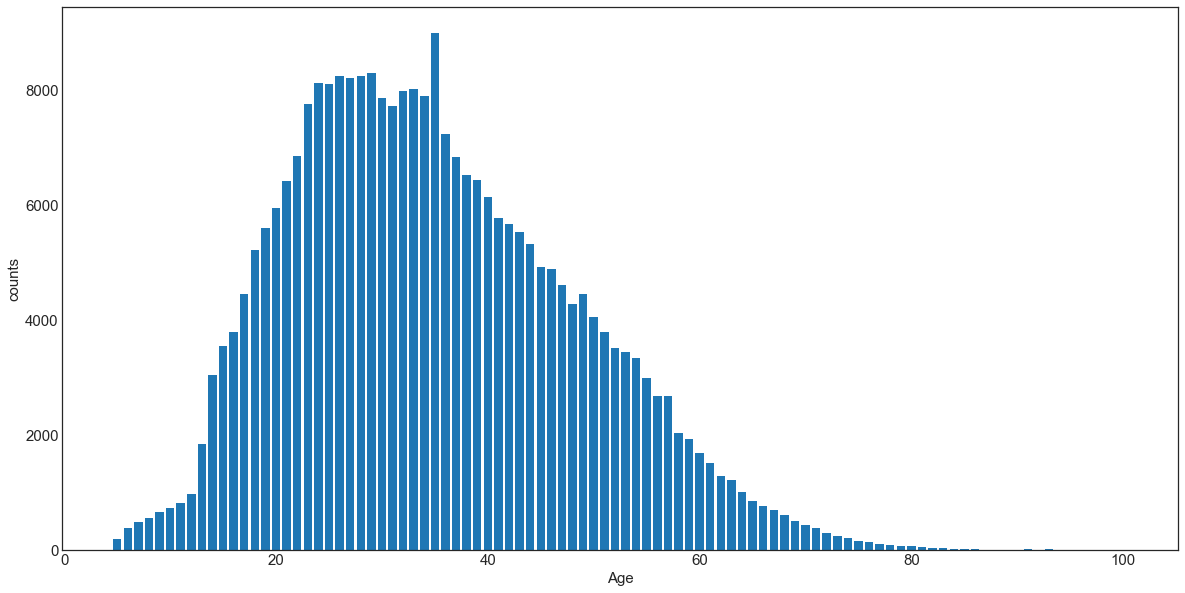

0.0

In [23]:
u = users1.Age.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 15}) # Set larger plot font size
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('counts')
plt.show()

users1.Age.isnull().sum() / len(users)

Exploring the countries of users

In [24]:
#users.Location.str.split(",")
#users[["City", "State", "Country"]] = users.Location.str.split(",", expand=True)

split_data = users1["Location"].str.split(",",2,expand=True)
split_data.columns = ["City", "State", "Country"]
users2 = users1.join(split_data)
del users2["Location"]

print(users2)




        User_id  Age         City             State          Country
0             1   30          nyc          new york              usa
1             2   18     stockton        california              usa
2             3   62       moscow   yukon territory           russia
3             4   17        porto          v.n.gaia         portugal
4             5   46  farnborough             hants   united kingdom
...         ...  ...          ...               ...              ...
278853   278854   33     portland            oregon              usa
278854   278855   50       tacoma        washington   united kingdom
278855   278856   54     brampton           ontario           canada
278856   278857   35    knoxville         tennessee              usa
278857   278858   26       dublin               n/a          ireland

[278858 rows x 5 columns]


In [25]:
users2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User_id  278858 non-null  int64 
 1   Age      278858 non-null  int32 
 2   City     278858 non-null  object
 3   State    278857 non-null  object
 4   Country  278856 non-null  object
dtypes: int32(1), int64(1), object(3)
memory usage: 9.6+ MB


In [26]:
users2['City'].value_counts().sort_values(ascending=False)

london                4105
barcelona             2664
toronto               2342
madrid                1933
sydney                1884
                      ... 
bencubbin                1
n.walsham                1
halls                    1
cupertino/san jose       1
stenhamra                1
Name: City, Length: 32770, dtype: int64

In [27]:
users2['Country'].value_counts()

 usa                                     139183
 canada                                   21556
 united kingdom                           18286
 germany                                  17021
 spain                                    13088
                                          ...  
 swazilandia                                  1
 national capital region, philippines         1
 valtesse                                     1
 texas, afghanistan                           1
 ohio                                         1
Name: Country, Length: 1276, dtype: int64

**Based on the values missing We will use the City for the analysis of the users and we will drop the Country and the State as most of the countries does not have states.**

In [28]:
print((users2["City"].values == '').sum())
print((users2["City"].isnull().sum()))

122
0


In [29]:
nan_value = float("NaN")
users2.replace("", nan_value, inplace=True)
users2.dropna(subset = ["City"], inplace=True)

In [30]:
print((users2["City"].values == '').sum())
print((users2["City"].isnull().sum()))

0
0


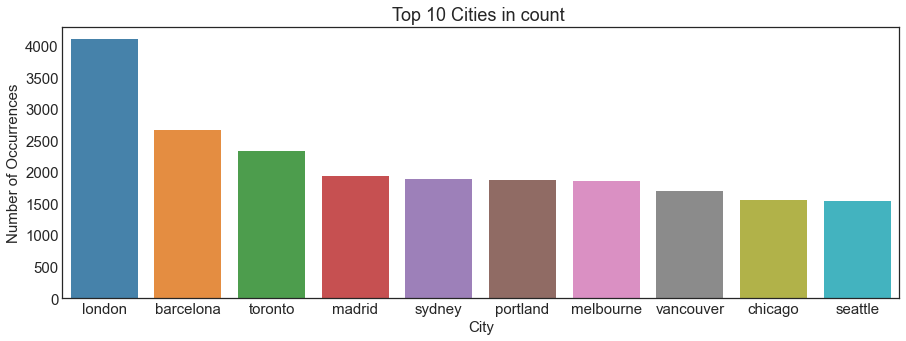

In [31]:
city_count  = users2["City"].value_counts()
city_count = city_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(city_count.index, city_count.values, alpha=0.9)
plt.title('Top 10 Cities in count ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('City', fontsize=15)
plt.show()

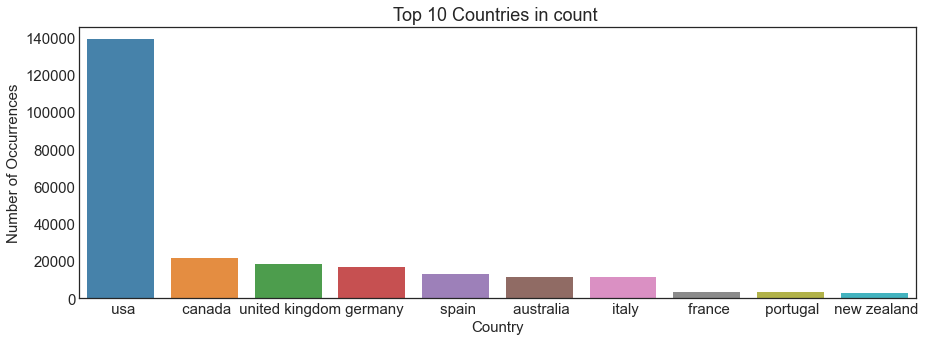

In [32]:
country_count  = users2["Country"].value_counts()
country_count = country_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(country_count.index, country_count.values, alpha=0.9)
plt.title('Top 10 Countries in count ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Country', fontsize=15)
plt.show()

## Exploring and Cleaning Books data set

In [33]:
# first drop the image columns from the data set
books.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [34]:
books.drop(['Image-URL-S','Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

In [35]:
print(books.dtypes)
books.columns = ['ISBN',"Book_title","Book_Author","Year_of_Publication","Publisher"]
print(books.info())
print(books.describe())

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Publisher              object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book_title           271379 non-null  object
 2   Book_Author          271378 non-null  object
 3   Year_of_Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.4+ MB
None
       Year_of_Publication
count        271379.000000
mean           1959.756050
std             258.011363
min               0.000000
25%            1989.000000
50%            1995.000000
75%            2000.000000
max            2050.000000


In [36]:
# check for na and empty with the columns of the books dataset
books_na = books.isna().sum()
books_null = books.isnull().sum()

title_empty = books[books.Book_title == ""].Book_title .count()
Author_empty = books[books.Book_Author == ""].Book_Author.count()
year_empty = books[books.Year_of_Publication == 0].Year_of_Publication.count()
Publisher_empty = books[books.Publisher == ""].Publisher.count()

print(f'count of na in the books:\\ {books_na}')
print(f'count of null in the books:\\ {books_null}')
print(f'count of  cells in the title:\\ {100*title_empty/books.Book_title.count()} %')
print(f'count of empty cells in the Author:\\ {100*Author_empty/books.Book_Author.count()} %')
print(f'count of cells in the years with "0":\\ {100*year_empty/books.Year_of_Publication.count()} %')
print(f'count of empty cells in the Publisher:\\ {100*Publisher_empty/books.Publisher.count()} %')



count of na in the books:\ ISBN                   0
Book_title             0
Book_Author            1
Year_of_Publication    0
Publisher              2
dtype: int64
count of null in the books:\ ISBN                   0
Book_title             0
Book_Author            1
Year_of_Publication    0
Publisher              2
dtype: int64
count of  cells in the title:\ 0.0 %
count of empty cells in the Author:\ 0.0 %
count of cells in the years with "0":\ 1.7020476897622883 %
count of empty cells in the Publisher:\ 0.0 %


In [37]:
# Replace all years of zero with NaN
books.Year_of_Publication.replace(0, np.nan, inplace=True)

nan_value = float("NaN")
books.replace("", nan_value, inplace=True)
books.dropna(subset = ["Book_title"], inplace=True)
books.dropna(subset = ["Year_of_Publication"], inplace=True)
books.dropna(subset = ["Book_Author"], inplace=True)
books.dropna(subset = ["Publisher"], inplace=True)

In [38]:
# check for na and empty with the columns of the books dataset
books_na = books.isna().sum()
books_null = books.isnull().sum()

title_empty = books[books.Book_title == ""].Book_title .count()
Author_empty = books[books.Book_Author == ""].Book_Author.count()
year_empty = books[books.Year_of_Publication == 0].Year_of_Publication.count()
Publisher_empty = books[books.Publisher == ""].Publisher.count()

print(f'count of na in the books:\\ {books_na}')
print(f'count of null in the books:\\ {books_null}')
print(f'count of  cells in the title:\\ {100*title_empty/books.Book_title.count()} %')
print(f'count of empty cells in the Author:\\ {100*Author_empty/books.Book_Author.count()} %')
print(f'count of cells in the years with "0":\\ {100*year_empty/books.Year_of_Publication.count()} %')
print(f'count of empty cells in the Publisher:\\ {100*Publisher_empty/books.Publisher.count()} %')


count of na in the books:\ ISBN                   0
Book_title             0
Book_Author            0
Year_of_Publication    0
Publisher              0
dtype: int64
count of null in the books:\ ISBN                   0
Book_title             0
Book_Author            0
Year_of_Publication    0
Publisher              0
dtype: int64
count of  cells in the title:\ 0.0 %
count of empty cells in the Author:\ 0.0 %
count of cells in the years with "0":\ 0.0 %
count of empty cells in the Publisher:\ 0.0 %


In [39]:
#Checking the books years range
print(books.describe())



       Year_of_Publication
count        266757.000000
mean           1993.689534
std               8.326039
min            1376.000000
25%            1989.000000
50%            1996.000000
75%            2000.000000
max            2050.000000


### It seems there are books that has dates of 1376 and books that has future dates. all of this will be cosidered as wrong inputs, so lets check the count of these books

In [40]:
#print(old_books = books[books.Year_of_Publication<1900])
print(f'outlaiers with old dates: {books[books.Year_of_Publication <1900].Year_of_Publication.count()}')
print(f'outlaiers with future dates: {books[books.Year_of_Publication >2019].Year_of_Publication.count()}')


print(f'Based on the count of the outlaiers we will remove the the rows for these books')

outlaiers with old dates: 4
outlaiers with future dates: 17
Based on the count of the outlaiers we will remove the the rows for these books


In [41]:
books = books[books['Year_of_Publication'] >= 1900 ]  
books = books[books['Year_of_Publication'] <= 2019 ]  
print(books.describe())
print(books.count())

       Year_of_Publication
count        266736.000000
mean           1993.692887
std               8.137504
min            1900.000000
25%            1989.000000
50%            1996.000000
75%            2000.000000
max            2012.000000
ISBN                   266736
Book_title             266736
Book_Author            266736
Year_of_Publication    266736
Publisher              266736
dtype: int64


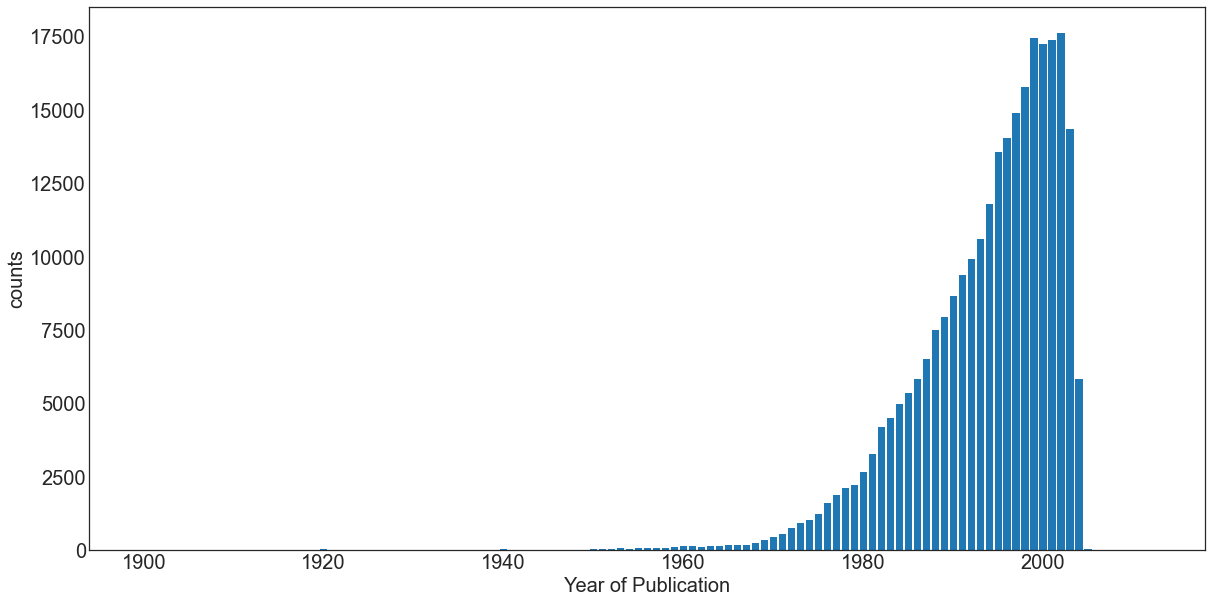

In [42]:
# plot to show the years destribution

yr = books.Year_of_Publication.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 20}) 
plt.bar(yr.index, yr.values)
plt.xlabel('Year of Publication')
plt.ylabel('counts')
plt.show()

In [43]:
books.head(20)


,ISBN,Book_title,Book_Author,Year_of_Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company
5,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group
7,0671870432,PLEADING GUILTY,Scott Turow,1993.0,Audioworks
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996.0,Random House
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Scribner


It seems there is a problem with the "&" in the publisher name

In [44]:
books.Publisher = books.Publisher.str.replace('&amp', '&', regex=False)

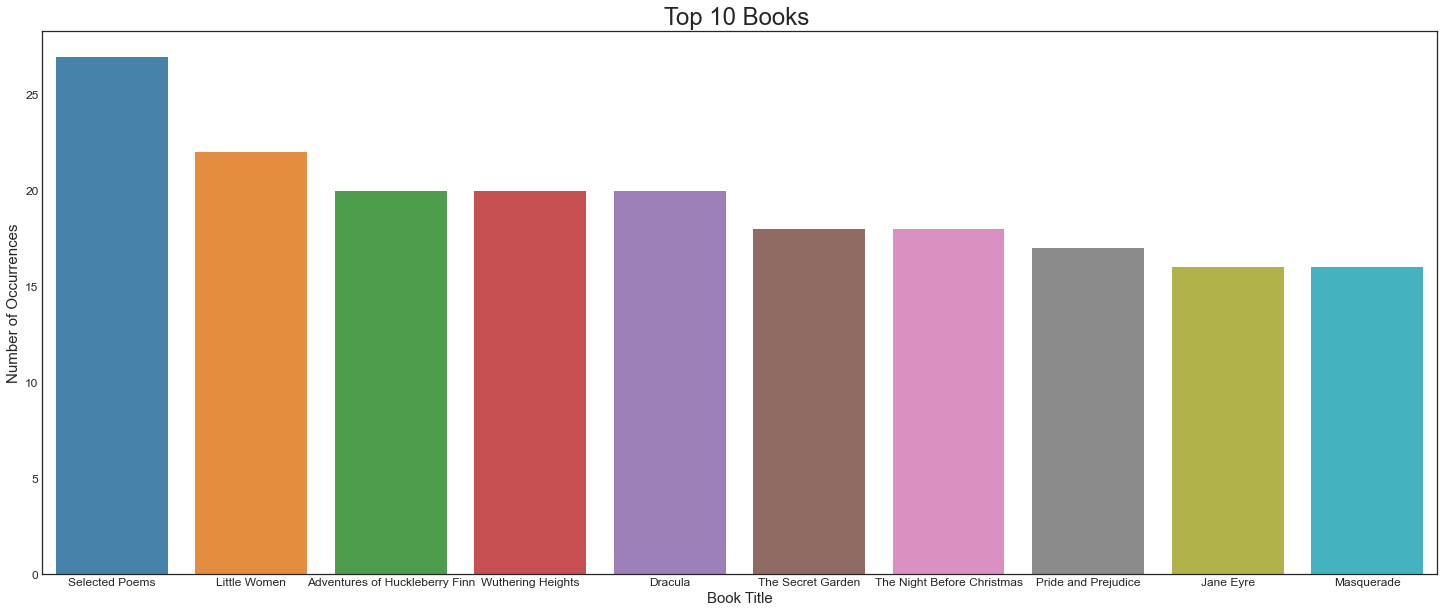

In [45]:
Top_books  = books["Book_title"].value_counts()
Top_books = Top_books[:10,]
plt.figure(figsize=(25,10))
sns.barplot(Top_books.index, Top_books.values, alpha=0.9)
plt.title('Top 10 Books ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Book Title', fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

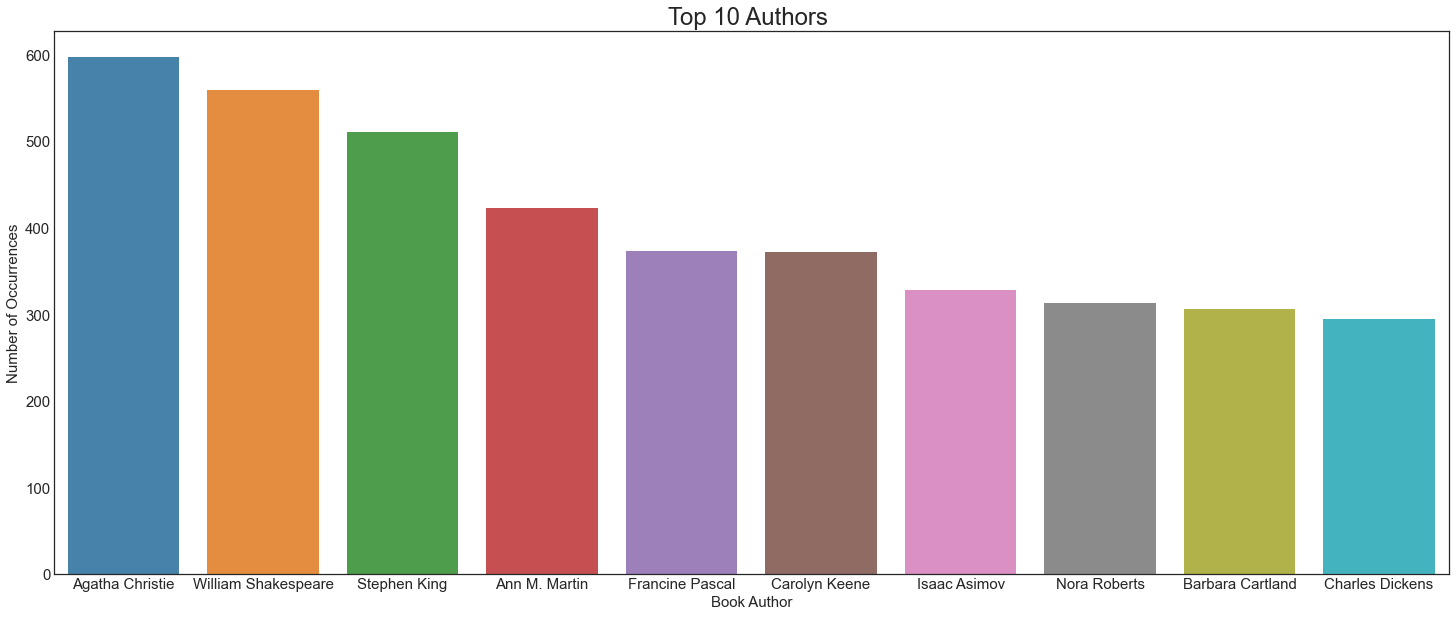

In [46]:
Top_Author  = books["Book_Author"].value_counts()
Top_Author = Top_Author[:10,]
plt.figure(figsize=(25,10))
sns.barplot(Top_Author.index, Top_Author.values, alpha=0.9)
plt.title('Top 10 Authors ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Book Author', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

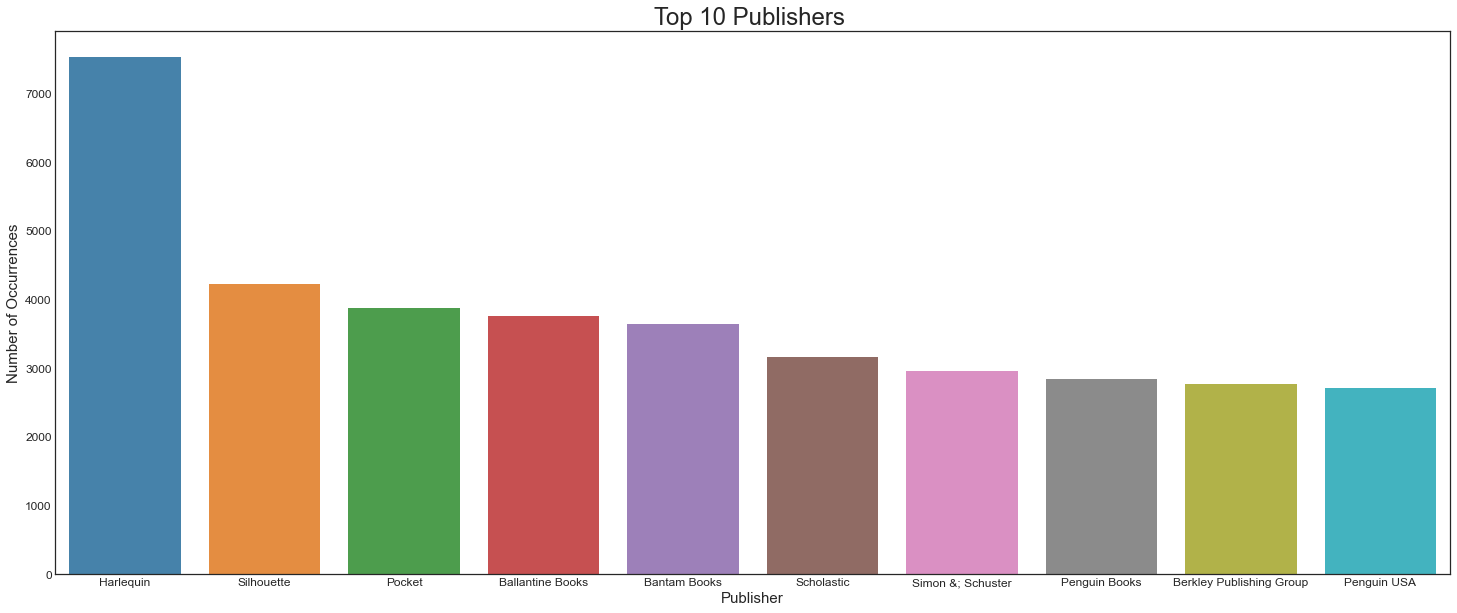

In [47]:
Top_Publisher  = books["Publisher"].value_counts()
Top_Publisher = Top_Publisher[:10,]
plt.figure(figsize=(25,10))
sns.barplot(Top_Publisher.index, Top_Publisher.values, alpha=0.9)
plt.title('Top 10 Publishers ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Publisher', fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

In [48]:
# checking for duplicate books 
print(books[(books.duplicated(['Book_title', 'Book_Author'], keep=False))].describe(include=[object]))
print(books[(books.duplicated(['Book_title', 'Book_Author'], keep='first'))].describe(include=[object]))
print(books[(books.duplicated(['Book_title', 'Book_Author']))].Book_Author.value_counts().head())

              ISBN                      Book_title      Book_Author  \
count        34936                           34936            34936   
unique       34936                           15057             7577   
top     0671606573  Adventures of Huckleberry Finn  Agatha Christie   
freq             1                              20              249   

               Publisher  
count              34936  
unique              2370  
top     Ballantine Books  
freq                1082  
              ISBN                      Book_title   Book_Author  \
count        19524                           19524         19524   
unique       19524                           15057          7577   
top     0800756509  Adventures of Huckleberry Finn  Stephen King   
freq             1                              19           183   

               Publisher  
count              19524  
unique              1912  
top     Ballantine Books  
freq                 583  
Stephen King           183
Agatha

In [49]:
# it seems that the boos are duplicated due to differnet publishers over the world. so we will use only one version of the books to avoid duplicates in the recomender model her is an example for the book of "Life of Pi'"
books[books.Book_title=='Life of Pi']

,ISBN,Book_title,Book_Author,Year_of_Publication,Publisher
246,0151008116,Life of Pi,Yann Martel,2002.0,Harcourt
563,0156027321,Life of Pi,Yann Martel,2003.0,Harvest Books
8745,1565117794,Life of Pi,Yann Martel,2003.0,Highbridge Audio
62892,184195425X,Life of Pi,Yann Martel,2004.0,Pub Group West


In [50]:
#Eliminating the duplications of books
books = books.drop_duplicates(['Book_title', 'Book_Author'])
books.describe(include=[object,int])

,ISBN,Book_title,Book_Author,Publisher
count,247212,247212,247212,247212
unique,247212,238512,100667,16224
top,0425141012,Selected Poems,William Shakespeare,Harlequin
freq,1,25,490,7508


In [51]:
#Checking for the duplications
print(books[(books.duplicated(['Book_title', 'Book_Author'], keep=False))].describe(include=[object]))
print(books[(books.duplicated(['Book_title', 'Book_Author'], keep='first'))].describe(include=[object]))
print(books[(books.duplicated(['Book_title', 'Book_Author']))].Book_Author.value_counts().head())

books[books.Book_title=='Life of Pi']

       ISBN Book_title Book_Author Publisher
count     0          0           0         0
unique    0          0           0         0
top     NaN        NaN         NaN       NaN
freq    NaN        NaN         NaN       NaN
       ISBN Book_title Book_Author Publisher
count     0          0           0         0
unique    0          0           0         0
top     NaN        NaN         NaN       NaN
freq    NaN        NaN         NaN       NaN
Series([], Name: Book_Author, dtype: int64)


,ISBN,Book_title,Book_Author,Year_of_Publication,Publisher
246,0151008116,Life of Pi,Yann Martel,2002.0,Harcourt


## Exploring and Cleaning Books ratings set

In [52]:
ratings.columns = ['User_id',"ISBN","Rating"]
ratings.head()

,User_id,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


print(ratings.dtypes)
ratings.describe()

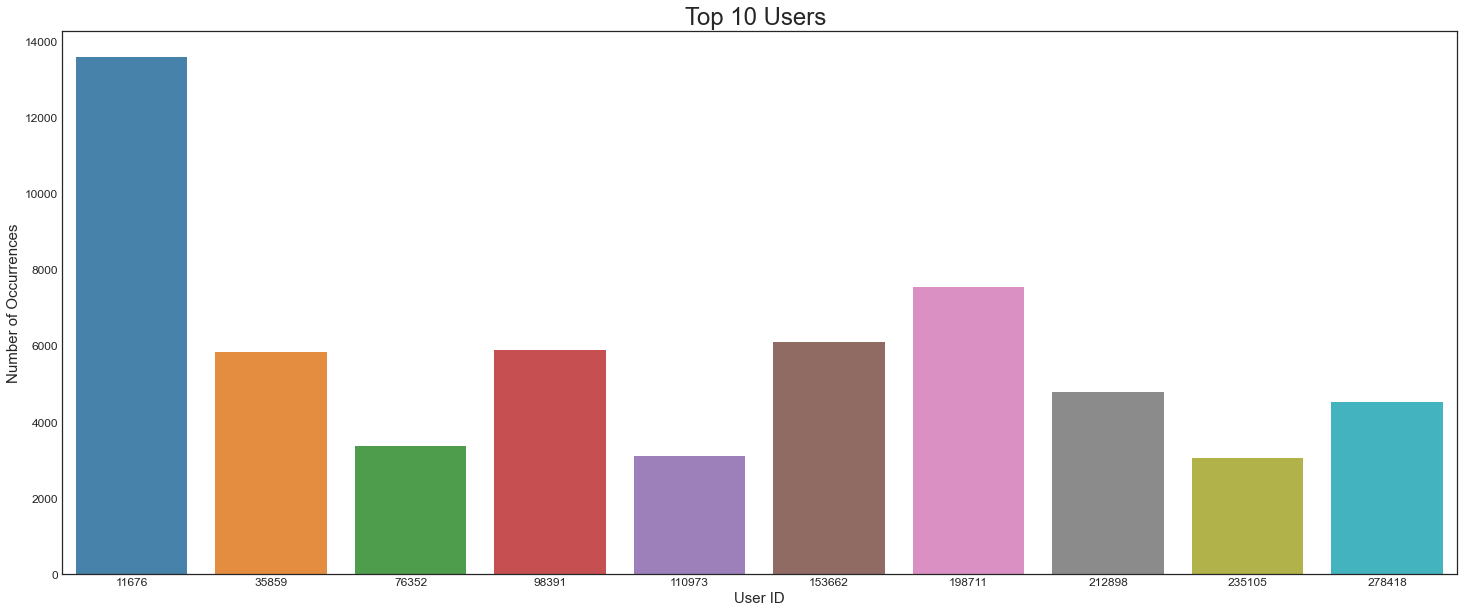

In [53]:
Top_user  = ratings["User_id"].value_counts()
Top_user = Top_user[:10,]
plt.figure(figsize=(25,10))
sns.barplot(Top_user.index, Top_user.values, alpha=0.9)
plt.title('Top 10 Users ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('User ID', fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

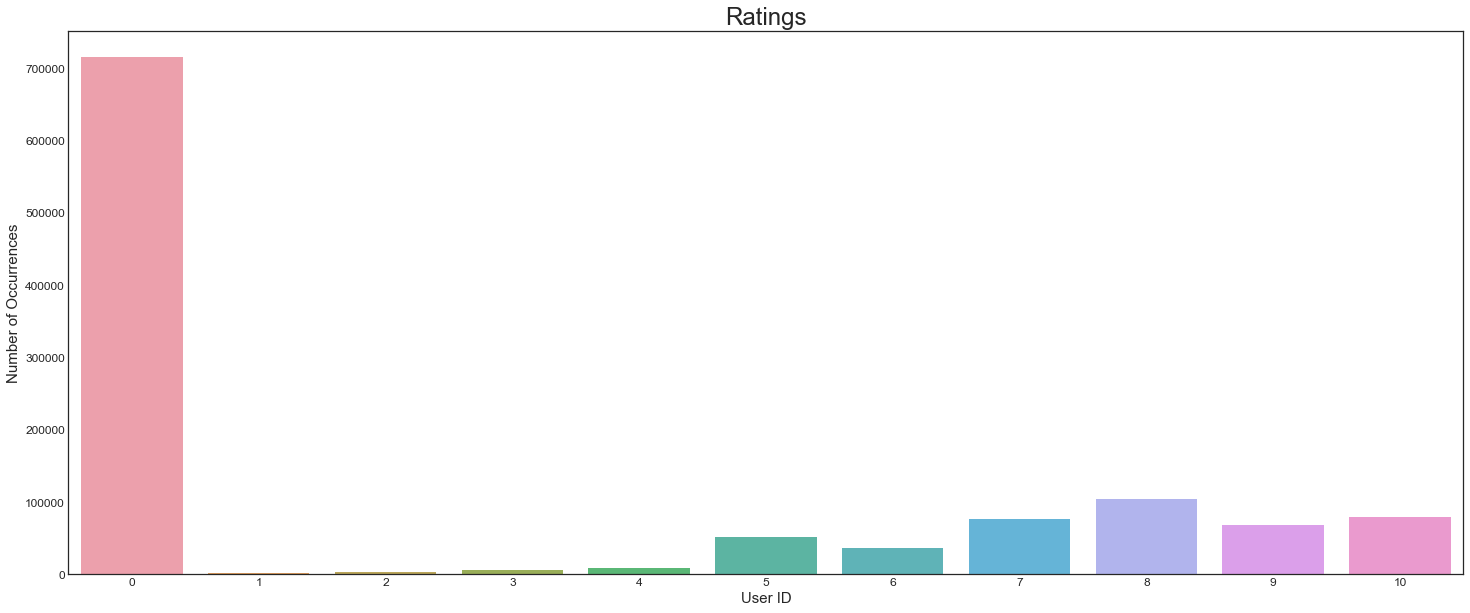

In [54]:
#Ratings destribution
Rate_distrbt  = ratings["Rating"].value_counts()
plt.figure(figsize=(25,10))
sns.barplot(Rate_distrbt.index, Rate_distrbt.values, alpha=0.9)
plt.title('Ratings')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('User ID', fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

Based on the describtion, these rating are implicit and explicit.  The explicit ratings represented by 1–10 and implicit ratings represented by 0 will have to be segregated now. We will be using only explicit ratings for building our book recommendation system. Similarly, users are also segregated into those who rated explicitly and those whose implicit behavior was recorded.

In [55]:
ratings = ratings[ratings.Rating != 0]

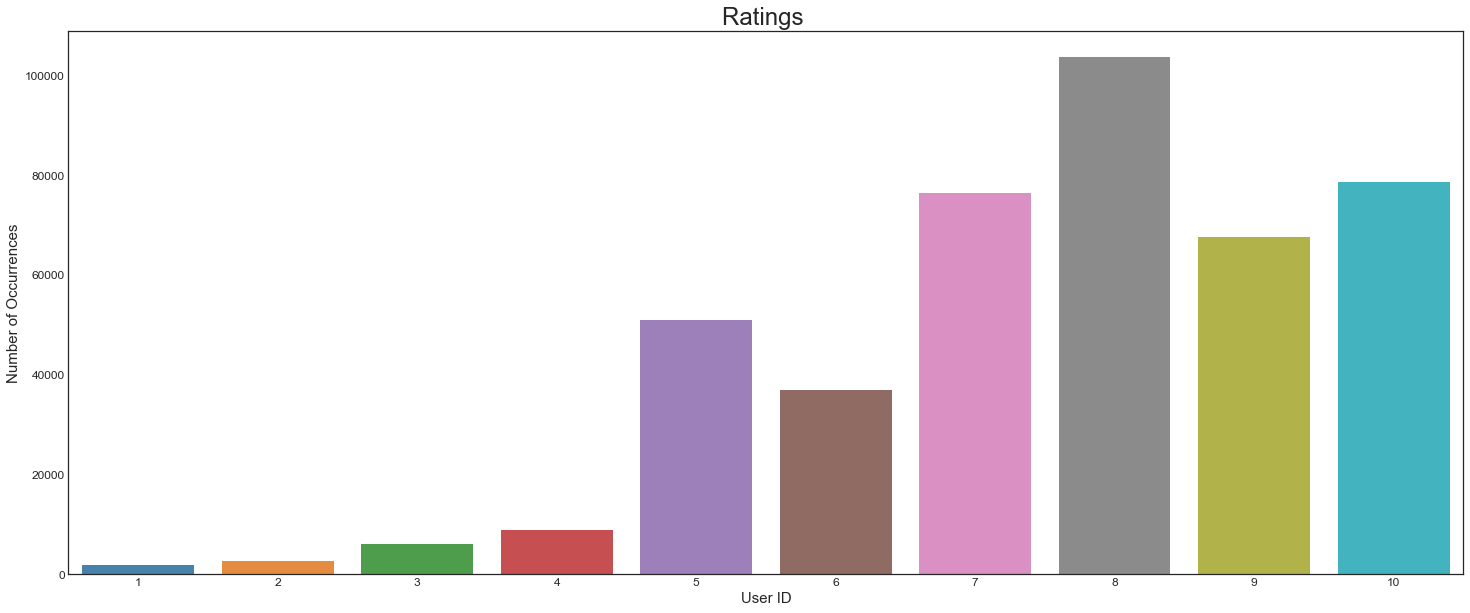

In [56]:
#Ratings destribution
Rate_distrbt = ratings["Rating"].value_counts()
plt.figure(figsize=(25,10))
sns.barplot(Rate_distrbt.index, Rate_distrbt.values, alpha=0.9)
plt.title('Ratings ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('User ID', fontsize=15)
plt.tick_params(labelsize=12)
plt.show()

## Joining the datasets

In [57]:
books_ratings = ratings.join(books.set_index('ISBN'), on='ISBN')

In [58]:
books_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433671 entries, 1 to 1149779
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User_id              433671 non-null  int64  
 1   ISBN                 433671 non-null  object 
 2   Rating               433671 non-null  int64  
 3   Book_title           335213 non-null  object 
 4   Book_Author          335213 non-null  object 
 5   Year_of_Publication  335213 non-null  float64
 6   Publisher            335213 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 26.5+ MB


In [59]:
books_ratings.head()

,User_id,ISBN,Rating,Book_title,Book_Author,Year_of_Publication,Publisher
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press
6,276736,3257224281,8,NaN,NaN,NaN,NaN
7,276737,0600570967,6,NaN,NaN,NaN,NaN


In [60]:
books_ratings.isnull().sum()

User_id                    0
ISBN                       0
Rating                     0
Book_title             98458
Book_Author            98458
Year_of_Publication    98458
Publisher              98458
dtype: int64

As per the above it seems that some ISBN that are rated has no books linked to them. this will be cleaned later

In [61]:
books_ratings.dropna(subset=['Book_title'], inplace=True) 

In [62]:
books_ratings.isnull().sum()

User_id                0
ISBN                   0
Rating                 0
Book_title             0
Book_Author            0
Year_of_Publication    0
Publisher              0
dtype: int64

In [63]:
#Join users data sets with books_ratings
ratings_wth_detls = books_ratings.join(users2.set_index('User_id'), on='User_id')

In [64]:
ratings_wth_detls.head()

,User_id,ISBN,Rating,Book_title,Book_Author,Year_of_Publication,Publisher,Age,City,State,Country
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle,34.0,seattle,washington,usa
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,16.0,rijeka,n/a,croatia
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,16.0,rijeka,n/a,croatia
8,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001.0,Doubleday,22.0,torrance,california,usa
16,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,HarperTorch,25.0,iowa city,iowa,usa


In [65]:
ratings_wth_detls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335213 entries, 1 to 1149778
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User_id              335213 non-null  int64  
 1   ISBN                 335213 non-null  object 
 2   Rating               335213 non-null  int64  
 3   Book_title           335213 non-null  object 
 4   Book_Author          335213 non-null  object 
 5   Year_of_Publication  335213 non-null  float64
 6   Publisher            335213 non-null  object 
 7   Age                  335115 non-null  float64
 8   City                 335115 non-null  object 
 9   State                334734 non-null  object 
 10  Country              326047 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 30.7+ MB


In [66]:
ratings_wth_detls.isnull().sum()

User_id                   0
ISBN                      0
Rating                    0
Book_title                0
Book_Author               0
Year_of_Publication       0
Publisher                 0
Age                      98
City                     98
State                   479
Country                9166
dtype: int64

In [67]:
# we will drop all the missing values from "age","city","State" and "Country"

ratings_wth_detls.dropna(subset=['Age','City','State','Country'], inplace=True) 

In [68]:
ratings_wth_detls.isnull().sum()

User_id                0
ISBN                   0
Rating                 0
Book_title             0
Book_Author            0
Year_of_Publication    0
Publisher              0
Age                    0
City                   0
State                  0
Country                0
dtype: int64

In [69]:
ratings_wth_detls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325666 entries, 1 to 1149778
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User_id              325666 non-null  int64  
 1   ISBN                 325666 non-null  object 
 2   Rating               325666 non-null  int64  
 3   Book_title           325666 non-null  object 
 4   Book_Author          325666 non-null  object 
 5   Year_of_Publication  325666 non-null  float64
 6   Publisher            325666 non-null  object 
 7   Age                  325666 non-null  float64
 8   City                 325666 non-null  object 
 9   State                325666 non-null  object 
 10  Country              325666 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 29.8+ MB


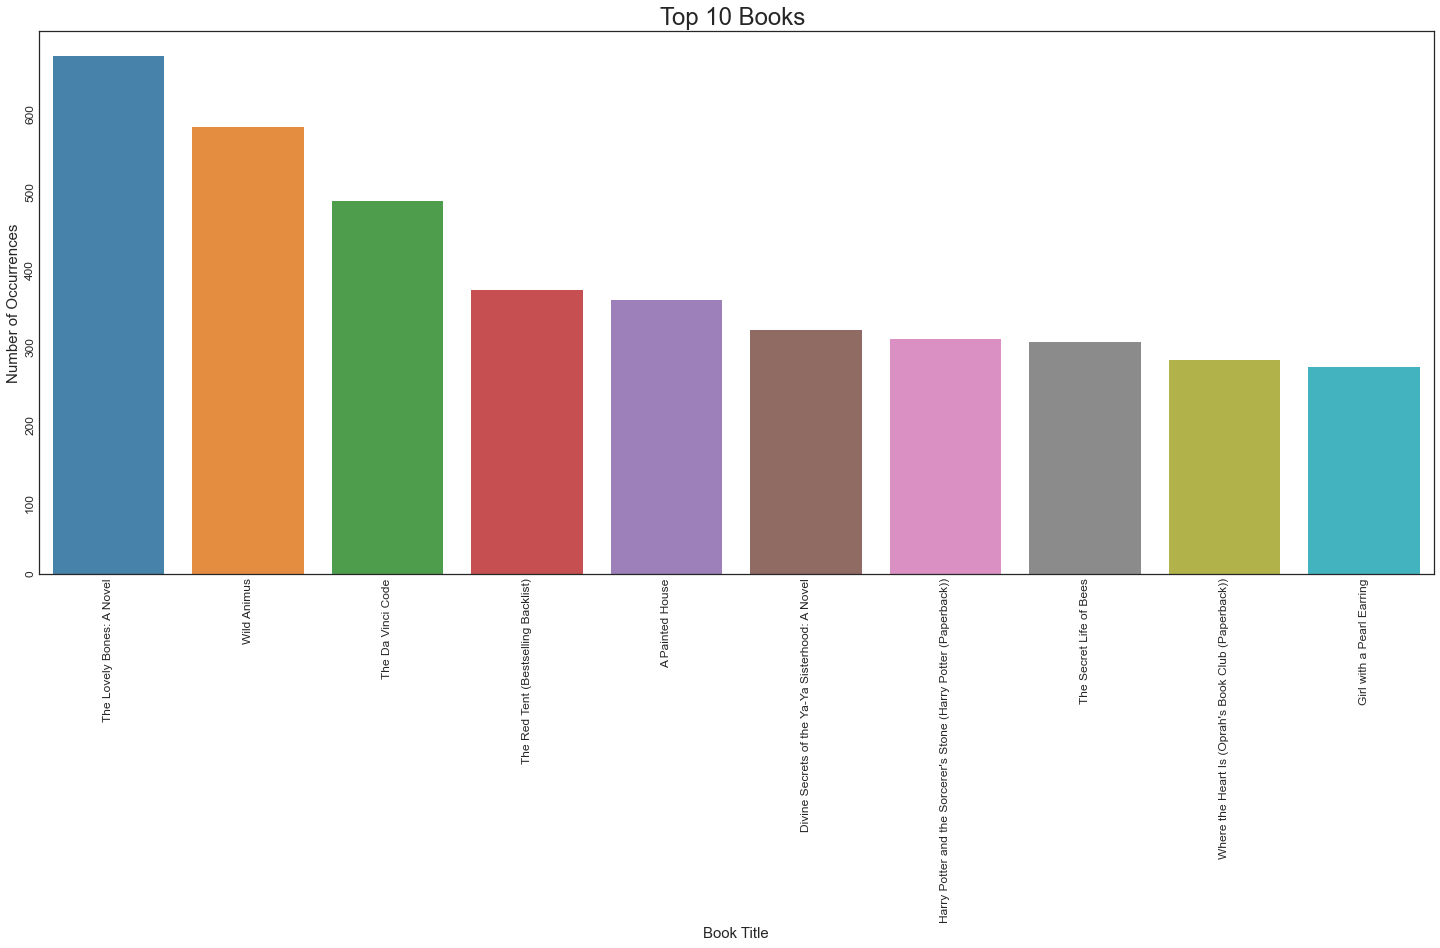

In [70]:
Top_books  = ratings_wth_detls["Book_title"].value_counts()
Top_books = Top_books[:10,]
plt.figure(figsize=(25,10))
sns.barplot(Top_books.index, Top_books.values, alpha=0.9)
plt.title('Top 10 Books ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('Book Title', fontsize=15)
plt.tick_params(labelsize=12, rotation=90)
plt.show()

In [71]:
BK_RT = ratings_wth_detls[['Book_title', 'Rating']]

BK_RT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325666 entries, 1 to 1149778
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Book_title  325666 non-null  object
 1   Rating      325666 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.5+ MB


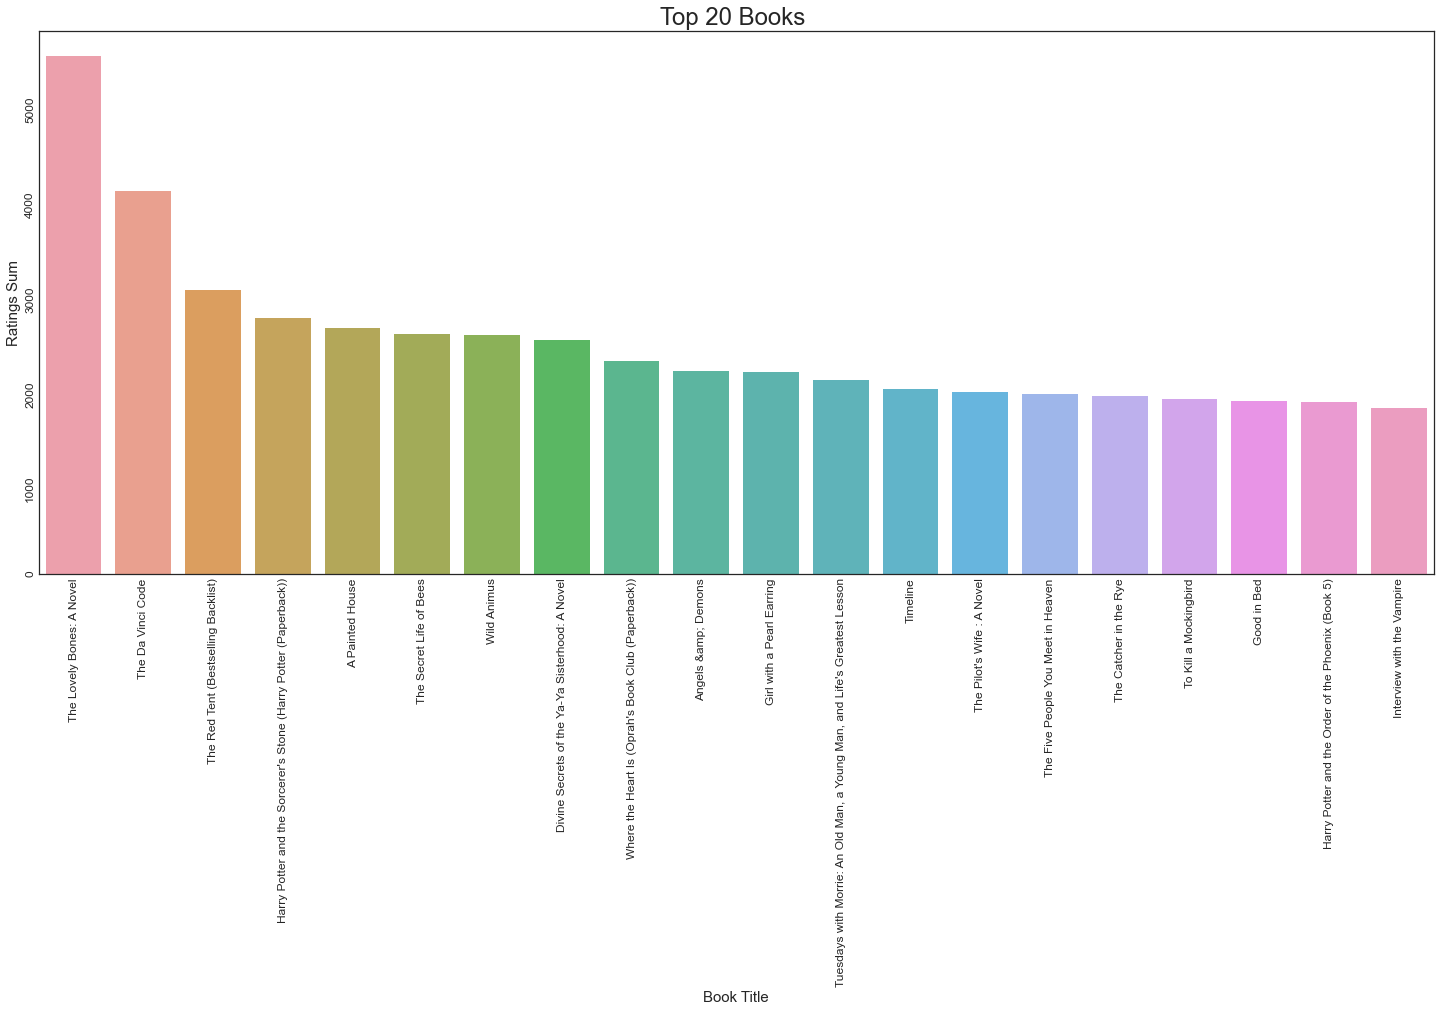

In [72]:
#Top 20 Books is the Rating totals
BR_sum = BK_RT.groupby('Book_title').Rating.sum()
BR_sum = BR_sum.sort_values(ascending=False)[:20]
plt.figure(figsize=(25,10))
sns.barplot(BR_sum.index, BR_sum.values, alpha=0.9)
plt.title('Top 20 Books ')
plt.ylabel('Ratings Sum', fontsize=15)
plt.xlabel('Book Title', fontsize=15)
plt.tick_params(labelsize=12, rotation=90 )
plt.show()

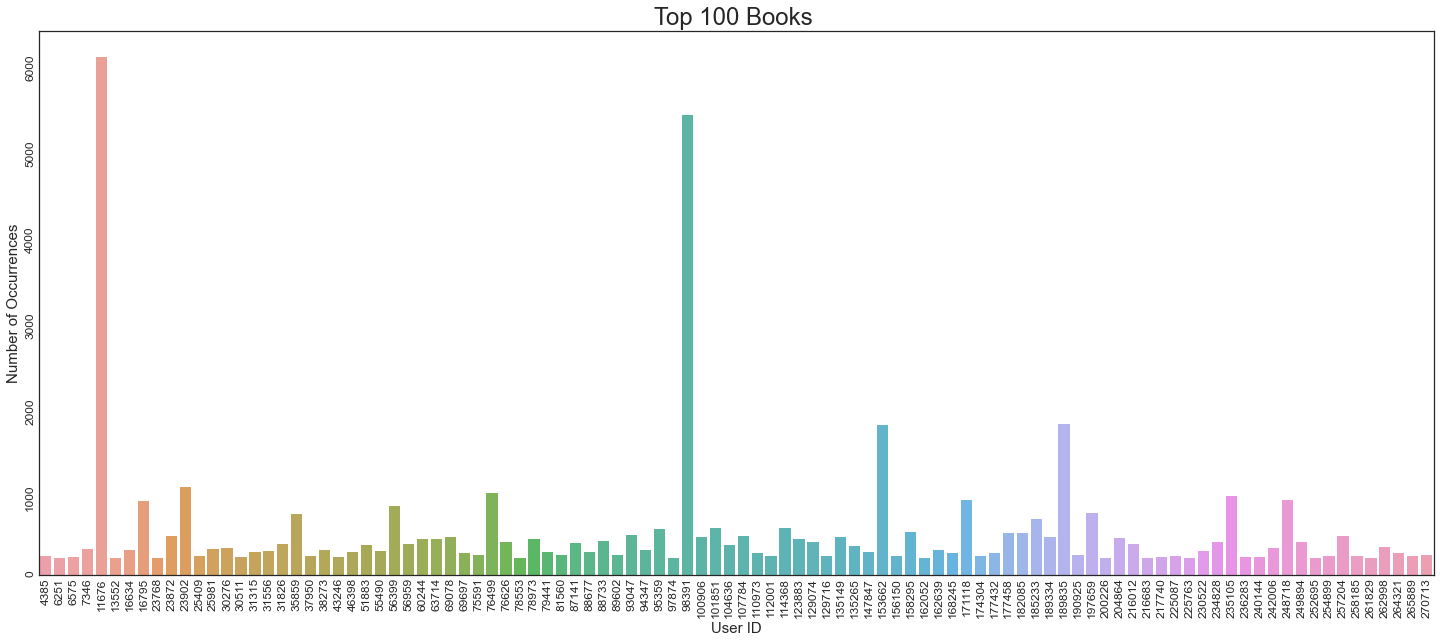

In [73]:
Top_user_id  = ratings_wth_detls["User_id"].value_counts()
Top_user_id = Top_user_id[:100,].sort_values()
plt.figure(figsize=(25,10))
sns.barplot(Top_user_id.index, Top_user_id.values, alpha=0.9)
plt.title('Top 100 Books ')
plt.ylabel('Number of Occurrences', fontsize=15)
plt.xlabel('User ID', fontsize=15)
plt.tick_params(labelsize=12, rotation=90)
plt.show()

# Recommendation systems


### Collaborative Filtering Based Recommendation Systems ###

# spliting the data into train and test data 


train_data.info()

In [74]:
ratings_wth_detls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325666 entries, 1 to 1149778
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User_id              325666 non-null  int64  
 1   ISBN                 325666 non-null  object 
 2   Rating               325666 non-null  int64  
 3   Book_title           325666 non-null  object 
 4   Book_Author          325666 non-null  object 
 5   Year_of_Publication  325666 non-null  float64
 6   Publisher            325666 non-null  object 
 7   Age                  325666 non-null  float64
 8   City                 325666 non-null  object 
 9   State                325666 non-null  object 
 10  Country              325666 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 29.8+ MB


In [75]:
df = pd.DataFrame(ratings_wth_detls)
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings_wth_detls[['User_id', 'ISBN', 'Rating']], reader)


In [157]:
df1 = pd.DataFrame(df[['User_id', 'ISBN', 'Rating']])

df2 = pd.DataFrame(df1[df1.groupby('User_id')['User_id'].transform('size') > 3])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263122 entries, 16 to 1149775
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User_id  263122 non-null  int64 
 1   ISBN     263122 non-null  object
 2   Rating   263122 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.0+ MB


In [159]:
data2 = Dataset.load_from_df(df2[['User_id', 'ISBN', 'Rating']], reader)

In [169]:
KNNWithMeansmodel = KNNWithMeans()

cv_results_knn= cross_validate(KNNWithMeansmodel, data2,  measures=['RMSE'], cv=5, verbose=True)
pd.DataFrame(cv_results_knn).mean()


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.8117  1.8206  1.8239  1.8179  1.8263  1.8201  0.0051  
Fit time          3.68    5.52    5.16    4.58    4.93    4.78    0.63    
Test time         1.29    1.26    1.51    1.36    1.31    1.34    0.09    


test_rmse    1.820088
fit_time     4.775407
test_time    1.343715
dtype: float64

In [166]:
KNNBasicmodel = KNNBasic()
cv_results_knnBas= cross_validate(KNNBasicmodel, data2,  measures=['RMSE'], cv=5, verbose=True)
pd.DataFrame(cv_results_knnBas).mean()

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9503  1.9663  1.9566  1.9592  1.9505  1.9566  0.0060  
Fit time          3.16    4.72    5.42    4.60    4.66    4.51    0.74    
Test time         1.30    1.90    2.58    1.62    1.29    1.74    0.48    


test_rmse    1.956573
fit_time     4.511229
test_time    1.736411
dtype: float64

In [78]:
model_svd = SVD()
cv_results_svd = cross_validate(model_svd, data, cv=3)
pd.DataFrame(cv_results_svd).mean()

test_rmse     1.643615
test_mae      1.270100
fit_time     11.445295
test_time     0.846186
dtype: float64

In [167]:

model_nmf = NMF()
cv_results_nmf = cross_validate(model_nmf, data, cv=3)
pd.DataFrame(cv_results_nmf).mean()

test_rmse     2.465247
test_mae      2.045409
fit_time     23.365788
test_time     1.092651
dtype: float64

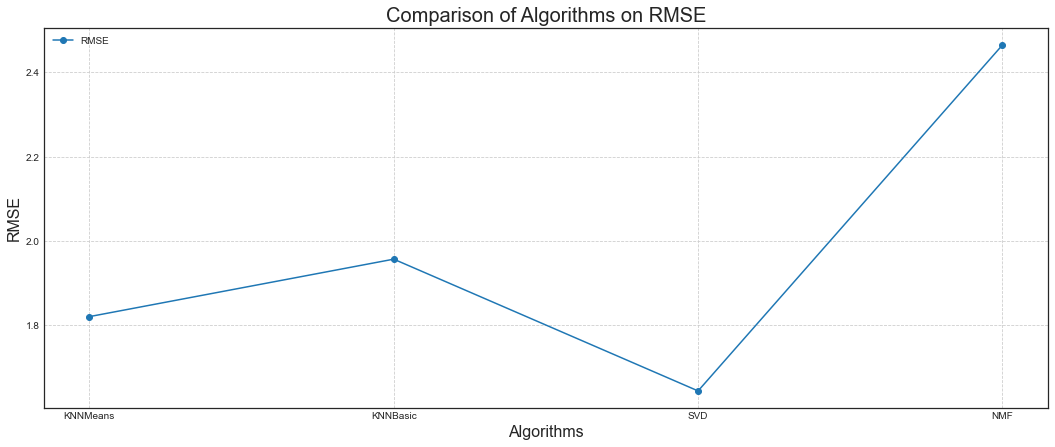

In [170]:
Algorithms = ['KNNMeans','KNNBasic','SVD', 'NMF']
#mannullt recode mean RMSE...since re-running takes too much time
rmse_results =[1.820088, 1.956573, 1.643615, 2.465247]

#rmse vs. algorithms
plt.figure(figsize=(18,7))
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=20)
plt.plot(Algorithms, rmse_results, label='RMSE', marker='o')
plt.xlabel('Algorithms', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.grid(ls='dashed')
plt.legend()
plt.show()

In [89]:

trainset, testset = train_test_split(data, test_size=0.2)

model = SVD(n_factors=60, n_epochs=30, lr_all=0.006, reg_all=0.2)
model.fit(trainset)
predictions = model.test(testset)

In [90]:
df_pred = pd.DataFrame(predictions, columns=['User_id', 'ISBN', 'actual_rating', 'pred_rating', 'details'])

df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)

df_pred.sample(5)

,User_id,ISBN,actual_rating,pred_rating,impossible,pred_rating_round,abs_err
9046,38273,0307000826,5.0,7.103657,False,7.0,2.103657
59179,231354,0380728133,9.0,7.883420,False,8.0,1.116580
32826,98391,0312875177,9.0,8.626779,False,9.0,0.373221
48409,114659,1558746099,5.0,7.352420,False,7.0,2.352420
56184,273197,074350030X,8.0,8.072991,False,8.0,0.072991


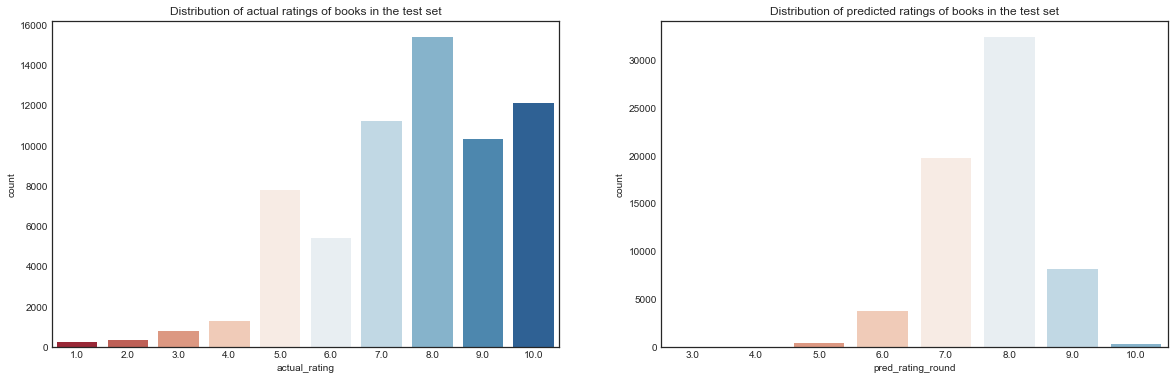

In [181]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

sns.countplot(x='actual_rating', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of books in the test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of books in the test set')

plt.show()

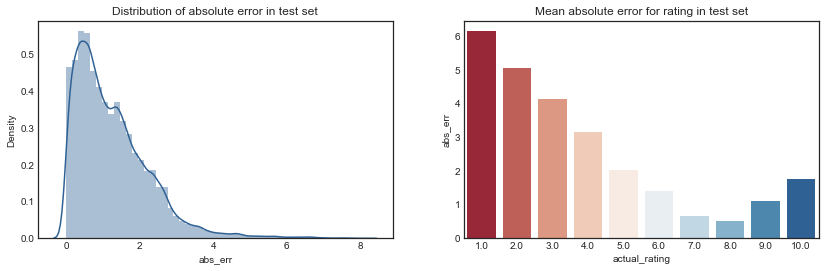

In [182]:
df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

In [183]:



df_ext = df.merge(df_pred[['ISBN', 'User_id','pred_rating']], on=['ISBN', 'User_id'], how='left')
df_ext.head(30)

,User_id,ISBN,Rating,Book_title,Book_Author,Year_of_Publication,Publisher,Age,City,State,Country,pred_rating
0,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle,34.0,seattle,washington,usa,NaN
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,16.0,rijeka,n/a,croatia,7.389863
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,16.0,rijeka,n/a,croatia,NaN
3,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001.0,Doubleday,22.0,torrance,california,usa,NaN
4,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,HarperTorch,25.0,iowa city,iowa,usa,NaN
5,276747,0671537458,9,Waiting to Exhale,Terry McMillan,1995.0,Pocket,25.0,iowa city,iowa,usa,7.084124
6,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,1997.0,Vintage Books USA,25.0,iowa city,iowa,usa,NaN
7,276747,0943066433,7,How to Deal With Difficult People,Rick Brinkman,1995.0,Careertrack Inc.,25.0,iowa city,iowa,usa,NaN
8,276747,1885408226,7,The Golden Rule of Schmoozing,Aye Jaye,1998.0,Listen &; Live Audio,25.0,iowa city,iowa,usa,NaN
9,276748,0747558167,6,Apricots on the Nile: A Memoir with Recipes,Colette Rossant,2002.0,Bloomsbury Publishing Plc,39.0,jubail ind.-city,eastern province,saudi arabia,7.801476


In [187]:

selected_user_id = 204864
df_user = df_ext[df_ext['User_id']==selected_user_id]

df_user[(df_user['pred_rating'].isna())&(df_user['Rating']>=7)].sample(30)

,User_id,ISBN,Rating,Book_title,Book_Author,Year_of_Publication,Publisher,Age,City,State,Country,pred_rating
245083,204864,0947533095,10,Sherlock Holmes and the Secret Seven (Sherlock...,Val Andrews,2001.0,Breese Books,47.0,simi valley,california,usa,NaN
244929,204864,0451207645,10,The Oath,John Lescroart,2003.0,Signet Book,47.0,simi valley,california,usa,NaN
244741,204864,0140430024,9,Middlemarch,George Eliot,1987.0,Penguin Books,47.0,simi valley,california,usa,NaN
244718,204864,0061092177,10,Small Gods (Discworld Novels (Paperback)),Terry Pratchett,1994.0,HarperTorch,47.0,simi valley,california,usa,NaN
245007,204864,0679732268,10,Light in August: The Corrected Text (Vintage I...,William Faulkner,1991.0,Vintage Books USA,47.0,simi valley,california,usa,NaN
244994,204864,0671884298,9,A LITTLE YELLOW DOG : Featuring an Original Ea...,Walter Mosley,1997.0,Pocket,47.0,simi valley,california,usa,NaN
244715,204864,006099486X,9,The Professor and the Madman: A Tale of Murder...,Simon Winchester,1999.0,Perennial,47.0,simi valley,california,usa,NaN
244826,204864,0380698714,10,Sideways Stories from Wayside School (Wayside ...,Louis Sachar,1985.0,HarperTrophy,47.0,simi valley,california,usa,NaN
244830,204864,0380705737,8,More Work for the Undertaker,Margery Allingham,1989.0,Harper Mass Market Paperbacks (Mm),47.0,simi valley,california,usa,NaN
244982,204864,0618001905,10,King Leopold's Ghost,Adam Hochschild,1999.0,Mariner Books,47.0,simi valley,california,usa,NaN


In [188]:
df_user[df_user['pred_rating'].notna()].sort_values('pred_rating', ascending=False).head(20)

,User_id,ISBN,Rating,Book_title,Book_Author,Year_of_Publication,Publisher,Age,City,State,Country,pred_rating
244981,204864,0609608444,10,"The Devil in the White City : Murder, Magic, a...",ERIK LARSON,2003.0,Crown,47.0,simi valley,california,usa,9.325796
244953,204864,0553209671,10,Sophies Choice,William Styron,1982.0,Bantam Doubleday Dell,47.0,simi valley,california,usa,9.156094
244921,204864,0449212602,10,The Handmaid's Tale,Margaret Atwood,1989.0,Fawcett Books,47.0,simi valley,california,usa,9.133998
244892,204864,0440940001,10,Island of the Blue Dolphins (Laurel Leaf Books),Scott O'Dell,1978.0,Laure Leaf,47.0,simi valley,california,usa,9.130088
245042,204864,0743474325,6,"Speaks the Nightbird, Volume I : Judgment of t...",Robert McCammon,2003.0,Pocket Books,47.0,simi valley,california,usa,9.035762
244970,204864,0553566040,9,Missing Joseph,Elizabeth George,1994.0,Bantam Books,47.0,simi valley,california,usa,9.027438
244777,204864,0312195516,10,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA,47.0,simi valley,california,usa,8.989473
244755,204864,0142001805,10,The Eyre Affair: A Novel,Jasper Fforde,2003.0,Penguin Books,47.0,simi valley,california,usa,8.971704
244728,204864,0140186409,10,The Grapes of Wrath (20th Century Classics),John Steinbeck,1992.0,Penguin Books,47.0,simi valley,california,usa,8.882971
244765,204864,0192833596,10,Great Expectations (Oxford World's Classics),Charles Dickens,1998.0,Oxford University Press,47.0,simi valley,california,usa,8.873647


In [189]:
df_user[df_user['pred_rating'].notna()].sort_values('Rating', ascending=False).head(20)

,User_id,ISBN,Rating,Book_title,Book_Author,Year_of_Publication,Publisher,Age,City,State,Country,pred_rating
244870,204864,0394805720,10,There's A Boy in the Girl's Bathroom,LOUIS SACHAR,1988.0,Yearling,47.0,simi valley,california,usa,8.133241
244926,204864,0451198808,10,South: The Endurance Expedition,Ernest Shackleton,1999.0,Signet Book,47.0,simi valley,california,usa,8.550093
245060,204864,0805012478,10,Steppenwolf,Hermann Hesse,1990.0,Henry Holt &; Company,47.0,simi valley,california,usa,8.598348
245044,204864,0750906871,10,The Wyvern Mystery,J. Sheridan Le Fanu,2000.0,Sutton Publishing,47.0,simi valley,california,usa,8.089663
244889,204864,0440402697,10,Crazy Mixed-Up Valentines (Creepy Creatures Cl...,Stephen Mooser,1990.0,Yearling Books,47.0,simi valley,california,usa,8.468661
244892,204864,0440940001,10,Island of the Blue Dolphins (Laurel Leaf Books),Scott O'Dell,1978.0,Laure Leaf,47.0,simi valley,california,usa,9.130088
244893,204864,0441004016,10,The Anubis Gates,Tim Powers,1997.0,Ace Books,47.0,simi valley,california,usa,8.527806
244914,204864,0446674249,10,L.A. Confidential,James Ellroy,1997.0,Warner Books,47.0,simi valley,california,usa,8.063301
244921,204864,0449212602,10,The Handmaid's Tale,Margaret Atwood,1989.0,Fawcett Books,47.0,simi valley,california,usa,9.133998
244934,204864,0451526392,10,Carmilla and 12 Other Classic Tales of Mystery,J. Sheridan Le Fanu,1996.0,Signet Classics,47.0,simi valley,california,usa,8.468661


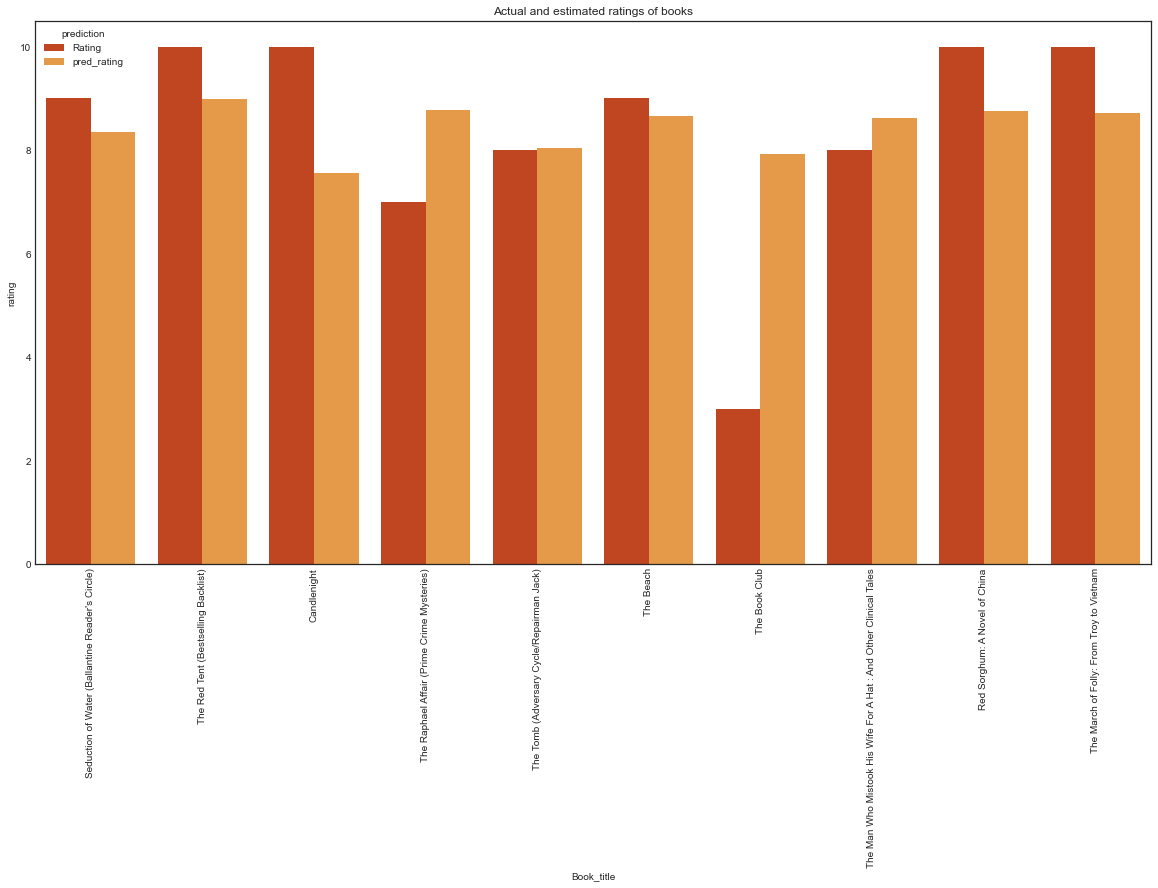

In [192]:

df_pred_sample = df_user[df_user['pred_rating'].notna()].sample(10)
df_pred_sample = pd.melt(df_pred_sample[['Book_title', 'Rating', 'pred_rating']], id_vars='Book_title', var_name='prediction', value_name='rating')

fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x='Book_title', y='rating', hue='prediction', data=df_pred_sample, palette=sns.color_palette("turbo_r"))
ax.set_title('Actual and estimated ratings of books')
plt.xticks(rotation=90)

plt.show()